In [135]:
# Laura Brancato (i6229390) 
# Olga Glazunova (i6369232)
# Simone Lamme (i6227946)
# Jorieke Schellekens (i6368804)
# Daphne Silvertand (i6227826) 
# Lena Strobl (i6368666)

In [136]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets as ds
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.stats import ttest_ind
import scipy.stats as st 

from miniML import *

In [137]:
# Load your data!
# ================

data = pd.read_excel("IID.xlsx")
# data = pd.read_excel("IID.xlsx").sample(1500)
target = data["Diagnosis"]
list_of_diagnoses = sorted(target.unique())

# if len(list_of_diagnoses) < 13:
#     raise Exception("The number of classes is less than 13. Reload samples.")

print(target.describe())
print("The list of diagnoses: ", list_of_diagnoses)

count                   11049
unique                     13
top       atrial_fibrillation
freq                     6037
Name: Diagnosis, dtype: object
The list of diagnoses:  ['atrial_fibrillation', 'atrial_flutter', 'brady_episode', 'bradycardia', 'extrasystoles_big_episode', 'extrasystoles_bigminy', 'extrasystoles_frequent', 'extrasystoles_isolated', 'extrasystoles_trig_episode', 'extrasystoles_trigeminy', 'sinus', 'tachy_episode', 'tachycardia']


In [138]:
# Getting Started with the basics!
# What is the a-priori distribution of your classes?
# ===================================================

# Method #1: Using numpy
# classes, occurrences = np.unique(target,return_counts=True)
# print("Classes: ", classes)
# print("Occurrences: ", occurrences)
# print("Prior probabilities: ", occurrences/len(target))

# Method # 2: Using pandas (since we are importing our dataset with pandas)
print("Prior probabilities: ", target.value_counts(normalize=True))

Prior probabilities:  Diagnosis
atrial_fibrillation           0.546384
sinus                         0.349534
extrasystoles_frequent        0.061997
extrasystoles_big_episode     0.019459
tachycardia                   0.008327
extrasystoles_trig_episode    0.004435
bradycardia                   0.002896
extrasystoles_bigminy         0.002172
extrasystoles_isolated        0.001810
atrial_flutter                0.001267
brady_episode                 0.000815
tachy_episode                 0.000543
extrasystoles_trigeminy       0.000362
Name: proportion, dtype: float64


In [139]:
# Display the highest probability among the target classes

print("The highest probability: ", getPrior(target))

The highest probability:  0.5463842881708751


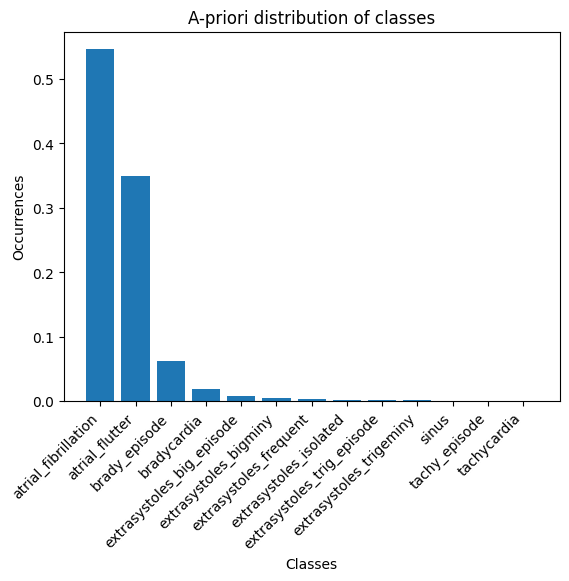

In [140]:
# Visualization of the a-priori distribution of our classes

classes = sorted(target.unique())
occurences = target.value_counts(normalize=True)

plt.bar(classes, occurences)
plt.xlabel('Classes')
plt.ylabel('Occurrences')
plt.title('A-priori distribution of classes')
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [141]:
# Features:
# Do you think you can use the features as they are, or do they need to be processed?
# * Translated to numerical values?
# * Scaled?
# * One-Hot Encoded?
# ===================================================================================

# Dropping the irrelevant features from the dataset: 'PatientId','RecordId','Creation Time'
# We don't delete the target column here because we use slicing later on to exclude it when necessary

data.drop(['PatientId','RecordId','Creation Time'], axis=1, inplace=True)

In [142]:
# Locate and handle missing values

print(data.isna().sum())
data['Symptoms'].fillna('no_symptoms', inplace=True)
data['Hb2'].fillna(data['Hb2'].mean(), inplace=True)

Diagnosis                0
Symptoms               163
Heart rate (BPM)         0
# Ectopics               0
Mean Intervals (ms)      0
SDNN(ms)                 0
SDSD(ms)                 0
RMSSD(ms)                0
pNN50(%)                 0
pNN20(%)                 0
zerosVs(%)               0
oneVs(%)                 0
twoLVs(%)                0
twoUVs(%)                0
Hstd(%)                  0
zeroVm(%)                0
oneVm(%)                 0
twoLVm(%)                0
twoUVm(%)                0
Hmm                      0
zeroVb1(%)               0
oneVb1(%)                0
twoVb1(%)                0
Hb1                      0
zeroVb2(%)               0
oneVb2(%)                0
twoVb2(%)                0
Hb2                      1
dtype: int64


In [143]:
# Replace values in the target column with numerical values

# Method #1: For numpy
# target = np.unique(target, return_inverse=True)[1].tolist()
# data['Diagnosis'] = target
# data.head()

# Method #2: For pandas (since we are importing our dataset with pandas)
classes_dict = {'atrial_fibrillation': 0, 'atrial_flutter': 1, 'brady_episode': 2, 'bradycardia': 3, 'extrasystoles_big_episode': 4, 'extrasystoles_bigminy': 5, 'extrasystoles_frequent': 6, 'extrasystoles_isolated': 7, 'extrasystoles_trig_episode': 8, 'extrasystoles_trigeminy': 9, 'sinus': 10, 'tachy_episode': 11, 'tachycardia': 12}
data["Diagnosis"] = data["Diagnosis"].str.lower().map(classes_dict)
print(data.tail())

# Reassign the target variable to the mapped values
target = data["Diagnosis"]

       Diagnosis               Symptoms  Heart rate (BPM)  # Ectopics  \
11044          0  palpitations, fatigue                85           0   
11045          0            no_symptoms                82           0   
11046          0           palpitations                95           0   
11047          0            no_symptoms                91           0   
11048          0           palpitations                84           0   

       Mean Intervals (ms)    SDNN(ms)    SDSD(ms)   RMSSD(ms)  pNN50(%)  \
11044           704.166667  186.112423  276.441664  274.694563  0.875000   
11045           730.864198  170.194152  274.401279  272.692338  0.839506   
11046           628.838951  149.087376  224.176900  222.899851  0.797753   
11047           661.044177  198.696244  284.689382  282.962455  0.807229   
11048           715.811966  221.155588  300.316281  298.360116  0.807692   

       pNN20(%)  ...  twoUVm(%)       Hmm  zeroVb1(%)  oneVb1(%)  twoVb1(%)  \
11044  0.950000  ...  50.

In [144]:
# One-hot encoding for the only categorical feature ('Symptoms')

data['Symptoms'] = data['Symptoms'].str.lower().str.replace(' ', '')
symptoms_dummies = data['Symptoms'].str.get_dummies(sep=',')
data = pd.concat([data, symptoms_dummies], axis=1)
data.drop(['Symptoms'], axis=1, inplace=True)
print(data.tail())

       Diagnosis  Heart rate (BPM)  # Ectopics  Mean Intervals (ms)  \
11044          0                85           0           704.166667   
11045          0                82           0           730.864198   
11046          0                95           0           628.838951   
11047          0                91           0           661.044177   
11048          0                84           0           715.811966   

         SDNN(ms)    SDSD(ms)   RMSSD(ms)  pNN50(%)  pNN20(%)  zerosVs(%)  \
11044  186.112423  276.441664  274.694563  0.875000  0.950000    8.974359   
11045  170.194152  274.401279  272.692338  0.839506  0.938272    7.594937   
11046  149.087376  224.176900  222.899851  0.797753  0.898876   13.793103   
11047  198.696244  284.689382  282.962455  0.807229  0.927711   16.049383   
11048  221.155588  300.316281  298.360116  0.807692  0.923077   25.000000   

       ...  twoVb2(%)       Hb2  chest_pains  confused  fatigue  lightheaded  \
11044  ...   3.896104  0.22423

In [145]:
# Doing it properly from the start!
# Initialize a classifier
# =================================

# Preparing the data: standardisation of the features
data_no_target = data.drop(['Diagnosis'], axis=1)
features_normalized = data_no_target - np.mean(data_no_target, axis=0) # mean normalization
features_normalized = (features_normalized / np.std(features_normalized, axis=0)) # standardization
data_normalized = pd.concat([target, features_normalized], axis=1) 

knn = KNNClassifier(k=10, norm=euclidNorm)

In [146]:
# Train and test your classifier in a cross-validation
# ====================================================

results_accuracy_knn=[]
predictions_knn=[]
matrix_size = len(np.unique(target))
confusion_matrix_knn = np.zeros((matrix_size,matrix_size))

# Enhanced confusionMatrix function from miniML.py in order to cover cases when len(np.unique(reference)) varies per fold (since not every fold can contain all classes)
def confusionMatrix(prediction, reference, matrix_size = None):
    if matrix_size == None:
        matrix_size = len(np.unique(reference))
    matrix = np.zeros((matrix_size,matrix_size))
    for s in range(len(reference)):
        matrix[reference[s],prediction[s]]+=1
    return matrix

for train,test in kfold(data_normalized.shape[0], k=10, shuffle=True):
    knn.fit(data_normalized.iloc[train,1:].values, data_normalized.iloc[train,0].values)
    prediction=knn.predict(data_normalized.iloc[test,1:].values)
    results_accuracy_knn.append(accuracy(prediction, target.iloc[test]))
    predictions_knn.append(prediction)
    
    cm_per_fold = confusionMatrix(prediction.astype(int),target.iloc[test].values.astype(int), matrix_size)
    confusion_matrix_knn += cm_per_fold
    
print("Accuracy for KNN: ", results_accuracy_knn)

Accuracy for KNN:  [0.9057971014492754, 0.9321266968325792, 0.9067873303167421, 0.9167420814479638, 0.9158371040723982, 0.9122171945701357, 0.9004524886877828, 0.9095022624434389, 0.8841628959276018, 0.9013574660633484]


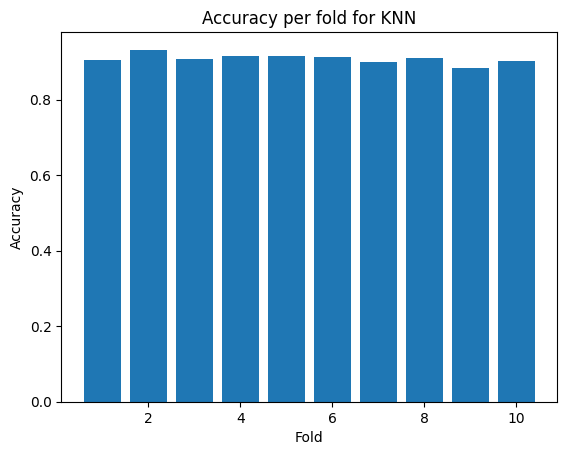

In [147]:
# Visualize your results with a bar plot? Can you even compare two classifers?
# ============================================================================

# Plot bar chart for KNN
plt.bar(range(1, len(results_accuracy_knn) + 1),results_accuracy_knn)
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy per fold for KNN')
plt.show()

In [148]:
# Train Parzen Window Classifier

pw = ParzenWindowClassifier(h=0.1)

results_accuracy_pw=[]
predictions_pw=[]
matrix_size = len(np.unique(target))
confusion_matrix_pw = np.zeros((matrix_size,matrix_size))
    
for train,test in kfold(data_normalized.shape[0],k=10,shuffle=True):
    pw.fit(data_normalized.iloc[train,1:].values, data_normalized.iloc[train,0].values)
    prediction=pw.predict(data_normalized.iloc[test,1:].values)
    results_accuracy_pw.append(accuracy(prediction, target.iloc[test]))
    predictions_pw.append(prediction)
    
    cm_per_fold = confusionMatrix(prediction.astype(int),target.iloc[test].values.astype(int), matrix_size)
    confusion_matrix_pw += cm_per_fold
    
print("Accuracy for Parzen Window: ", results_accuracy_pw)

Accuracy for Parzen Window:  [0.5434782608695652, 0.5556561085972851, 0.5610859728506787, 0.5294117647058824, 0.5475113122171946, 0.5158371040723982, 0.5529411764705883, 0.5574660633484163, 0.5520361990950227, 0.5484162895927602]


There is a statistically significant difference between the two classifiers.
Confidence interval for KNN:  (0.8999944779010121, 0.9170020464612414)
Confidence interval for Parzen Window:  (0.5369616856670435, 0.5558063646969148)


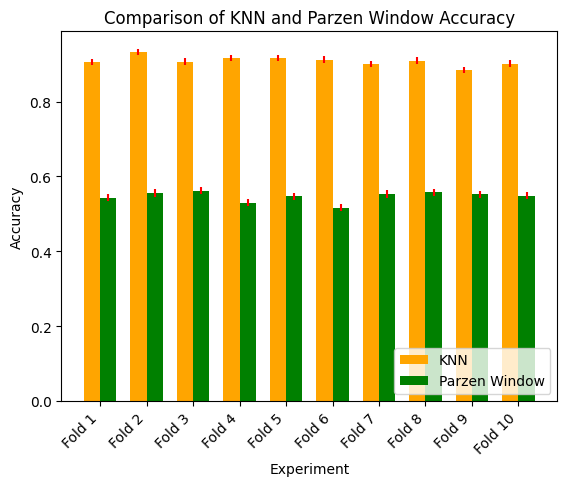

In [149]:
# Compare two classifiers: calculate t-test and plot comparison of KNN and Parzen Window results

bar_width = 0.35
color_bar1= 'orange'
color_bar2 = 'green'
color_errorbar = 'red'

def classifier_results_comparison(accuracy_1, accuracy_2, title_1, title_2):
    # Compare two classifiers: run t-test to check if there is a statistically significant difference between the two classifiers
    alpha = 0.05 # significance level
    t_stats = ttest_ind(accuracy_1, accuracy_2)    
    if t_stats[1] < alpha:
        print("There is a statistically significant difference between the two classifiers.")
    else:
        print("There is no statistically significant difference between the two classifiers.")
    
    indices = np.arange(len(accuracy_1))    
    plt.bar(indices, accuracy_1, bar_width, label=title_1, color=color_bar1)
    plt.bar(indices + bar_width, accuracy_2, bar_width, label=title_2, color=color_bar2)
    
    # compute standard error of the mean based on sample mean and sample standard deviation with alpha/2 confidence interval
    sem_1 = np.std(accuracy_1)/np.sqrt(len(accuracy_1))
    sem_2 = np.std(accuracy_2)/np.sqrt(len(accuracy_2))

    # create 95% confidence interval 
    confidence_interval_1 = st.t.interval(confidence=0.95, df=len(accuracy_1)-1, loc=np.mean(accuracy_1), scale=sem_1)
    confidence_interval_2 = st.t.interval(confidence=0.95, df=len(accuracy_2)-1, loc=np.mean(accuracy_2), scale=sem_2)

    # plot confidence interval
    plt.errorbar(indices, accuracy_1, yerr=confidence_interval_1[1]-np.mean(accuracy_1), fmt='none', color=color_errorbar)
    plt.errorbar(indices + bar_width, accuracy_2, yerr=confidence_interval_2[1]-np.mean(accuracy_2), fmt='none', color=color_errorbar)

    print("Confidence interval for " + title_1 + ": ", confidence_interval_1)
    print("Confidence interval for " + title_2 + ": ", confidence_interval_2)
    
    plt.xlabel("Experiment")
    plt.ylabel("Accuracy")
    plt.title("Comparison of " + title_1 + " and " + title_2 + " Accuracy")
    
    # Set the ticks at the center of each group of bars
    tick_positions = indices + bar_width / 2
    
    tick_labels = ['Fold {}'.format(i) for i in range(1, len(accuracy_1) + 1)]
    plt.xticks(tick_positions, tick_labels)
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.legend(loc='lower right')
    
    plt.show()
    
classifier_results_comparison(results_accuracy_knn, results_accuracy_pw, "KNN", "Parzen Window")

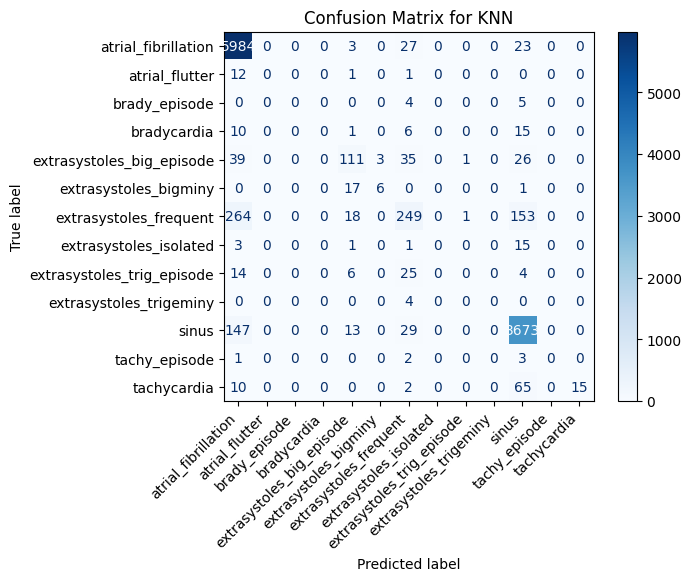

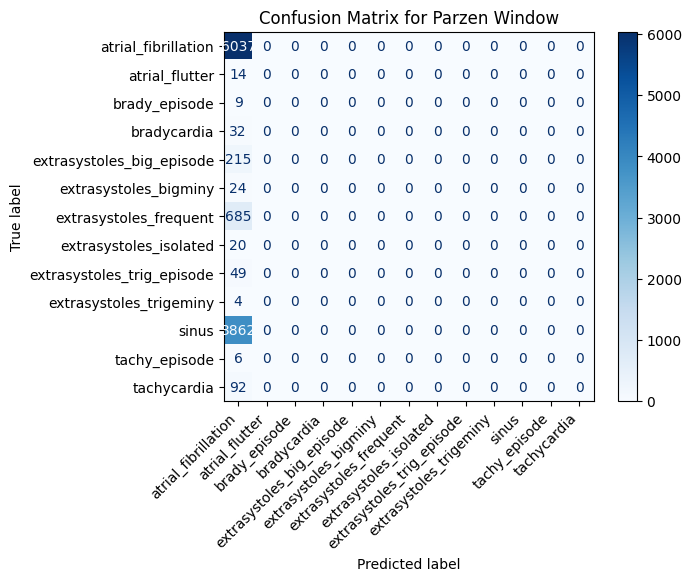

In [150]:
# Create a confusion matrix of your results!
# ==========================================

def plot_confusion_matrix(confusion_matrix, title):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,display_labels=np.unique(list_of_diagnoses))
    disp_knn = disp.plot(cmap=plt.cm.Blues,values_format='g')
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.title("Confusion Matrix for " + title)
    plt.show()

# Plot confusion matrix for KNN    
plot_confusion_matrix(confusion_matrix_knn, "KNN")

# Plot confusion matrix for Parzen Window    
plot_confusion_matrix(confusion_matrix_pw, "Parzen Window")

In [151]:
# Can you increase performance with feature selection?
# ====================================================

# We didn't use classical statistical tests, such as correlations, t-test, etc., because these methods are very sensitive in case of big amount of data (e.g., there is always a stastically significant difference for t-test when the sample contains a lot of instances), also, because we have >2 classes problem.

# We applied three feature selection methods that were mentioned in the slides: 
# the Greedy Forward Selection that selects the best existing features under the model in test, 
# the Fisher's Ratio that allows to rank features from the perspective of the linear discriminative power of a particular feature, 
# and the PCA that reduces the dimensionality of the data by constructing a new feature space taking into consideration the variance of the data in each new dimension.

In [152]:
# Greedy Forward Selection to select the best features

# First we downsample the data while making sure that each class is represented in the dataset.
# We downsample because the Greedy Forward Selection method takes (n * m) classifications + (n * m) 
# trainings where n is the number of all features and m is the number of features we select 
# so in our case n = 34 and m = 10, moreover, each training for KNN takes xd + kx performance time, 
# where x is the number of instances in the training set so in our case x = 11049, 
# d is the dimensionality of the data and k is the number of neighbors, 
# in addition, wrapperRanker is called kNested times for k-fold cross-validation. 
# As a result, we get (n * m) * (xd + kx) * kNested iterations for Greedy Forward Selection for KNN without
# downsampling, hence, we downsample the data and reduce the number of folds to reduce the running time of the method.

# Downsampling may result in the loss of some classes, so we run downsampling until we get all classes
list_of_classes = []
while len(list_of_classes) < 13:
    downsampled_data = data_normalized.sample(1500)
    target = downsampled_data["Diagnosis"]
    list_of_classes = sorted(target.unique())
    if len(list_of_classes) < 13:
        print("The number of classes is less than 13. Run downsampling again")

data_selected_features = wrapperRanker(downsampled_data.iloc[:,1:].values, downsampled_data.iloc[:,0].values, 10, knn, 2)

The number of classes is less than 13. Run downsampling again
The number of classes is less than 13. Run downsampling again
The number of classes is less than 13. Run downsampling again
The number of classes is less than 13. Run downsampling again
The number of classes is less than 13. Run downsampling again


In [153]:
# Training KNN with selected features (Greedy Forward Selection)

results_sf_accuracy_knn=[]
predictions_sf_knn=[]

for train,test in kfold(downsampled_data.shape[0], k=10, shuffle=True):
    knn.fit(downsampled_data.iloc[train,1:].values[:, data_selected_features], downsampled_data.iloc[train,0].values)
    prediction=knn.predict(downsampled_data.iloc[test,1:].values[:, data_selected_features])
    results_sf_accuracy_knn.append(accuracy(prediction, target.iloc[test]))
    predictions_sf_knn.append(prediction)    

print("Accuracy for KNN without selected features: ", results_accuracy_knn)
print("Accuracy for KNN with selected features: ", results_sf_accuracy_knn)

Accuracy for KNN without selected features:  [0.9057971014492754, 0.9321266968325792, 0.9067873303167421, 0.9167420814479638, 0.9158371040723982, 0.9122171945701357, 0.9004524886877828, 0.9095022624434389, 0.8841628959276018, 0.9013574660633484]
Accuracy for KNN with selected features:  [0.9266666666666666, 0.86, 0.94, 0.9466666666666667, 0.8533333333333334, 0.8866666666666667, 0.9266666666666666, 0.9066666666666666, 0.9, 0.9133333333333333]


There is no statistically significant difference between the two classifiers.
Confidence interval for KNN:  (0.8999944779010121, 0.9170020464612414)
Confidence interval for KNN with Greedy Forward Selection:  (0.8845181075179634, 0.9274818924820366)


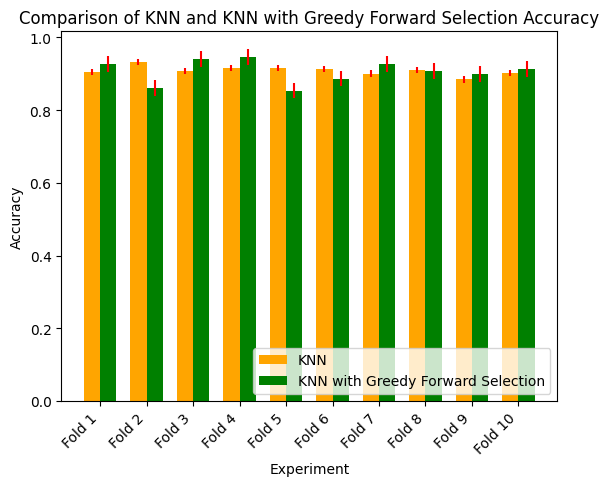

In [154]:
# Plot comparison of KNN with and without Greedy Forward Selection

classifier_results_comparison(results_accuracy_knn, results_sf_accuracy_knn, "KNN", "KNN with Greedy Forward Selection")

In [155]:
# Fisher's Ratio to select the 10 best features

data_selected_features_fisher = fisherRatioRanker(data_normalized.iloc[:,1:].values, data_normalized.iloc[:,0].values)
data_selected_features_fisher = data_selected_features_fisher[:10]
print(data_selected_features_fisher)

C:\_Uni\HDT4003\tutorial_4\miniML.py:169: RuntimeWarning: invalid value encountered in double_scalars
  fr = ((x-y)**2) / (s1+s2)


[33 18 31 30 29 28 27 26  8 15]


Accuracy for KNN without selected features:  [0.9057971014492754, 0.9321266968325792, 0.9067873303167421, 0.9167420814479638, 0.9158371040723982, 0.9122171945701357, 0.9004524886877828, 0.9095022624434389, 0.8841628959276018, 0.9013574660633484]
Accuracy for KNN with selected features:  [0.7780797101449275, 0.7710407239819005, 0.7900452488687782, 0.7746606334841629, 0.7619909502262443, 0.7864253393665158, 0.7846153846153846, 0.8018099547511313, 0.7954751131221719, 0.7782805429864253]
There is a statistically significant difference between the two classifiers.
Confidence interval for KNN:  (0.8999944779010121, 0.9170020464612414)
Confidence interval for KNN with Fisher's Ratio selected features:  (0.7741866897685737, 0.7902980305409547)


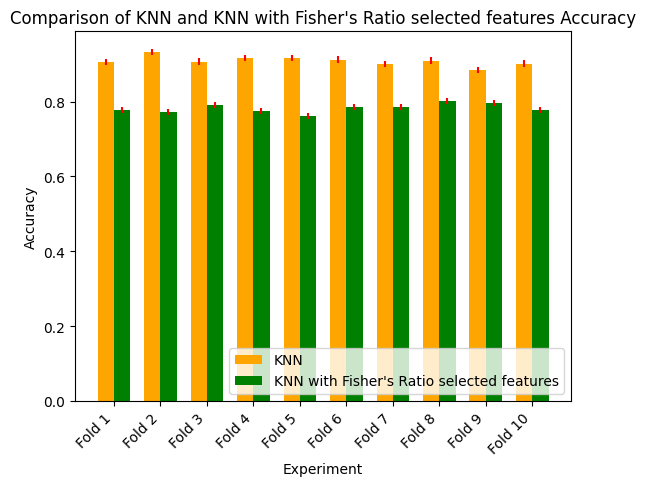

In [156]:
# Training KNN with selected features (Fisher's Ratio)
target = data_normalized["Diagnosis"]
results_fisher_selected_accuracy_knn=[]
predictions_fisher_selected_knn=[]

for train,test in kfold(data_normalized.shape[0], k=10, shuffle=True):
    knn.fit(data_normalized.iloc[train,1:].values[:, data_selected_features_fisher], data_normalized.iloc[train,0].values)
    prediction=knn.predict(data_normalized.iloc[test,1:].values[:, data_selected_features_fisher])
    results_fisher_selected_accuracy_knn.append(accuracy(prediction, target.iloc[test]))
    predictions_fisher_selected_knn.append(prediction)    

print("Accuracy for KNN without selected features: ", results_accuracy_knn)
print("Accuracy for KNN with selected features: ", results_fisher_selected_accuracy_knn)

# Plot comparison of KNN with and without Fisher's Ratio selected features
classifier_results_comparison(results_accuracy_knn, results_fisher_selected_accuracy_knn, "KNN", "KNN with Fisher's Ratio selected features")

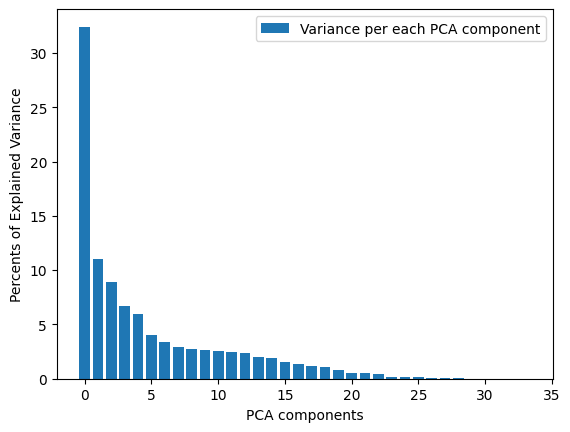

In [157]:
# Principle Component Analysis (PCA)

# Enhanced PCA function from miniML.py in order to return the sorted eigenvalues together with eigenvectors, to calculate the variance per each PCA component and to plot the variance per each PCA component
def pca(data):
    # Calculate Covariance Matrix
    cov=np.cov(data.T)
    # Calculate Eigenvalues and Eigenvectors
    w, v = np.linalg.eig(cov)
    # Sort them
    s= np.argsort(w)[::-1]
    return v[:,s], w[s] # return eigenvectors and eigenvalues sorted by eigenvalues

pca_components_eigenvalues = pca(data_normalized.iloc[:,1:].values)
components_by_variance = []
eig_values = pca_components_eigenvalues[1]

for eig in eig_values:   
    components_by_variance.append((eig/sum(eig_values))*100)
    
# Plot the variance per each PCA component to see how many components we need to keep   
plt.figure()
plt.bar(range(len(eig_values)), components_by_variance, label='Variance per each PCA component')
plt.ylabel('Percents of Explained Variance')
plt.xlabel('PCA components')
plt.legend()

# After looking at the plot, we decided to keep 10 components
pca_components = pca_components_eigenvalues[0][:10]
pca_projected_data = np.dot(data_normalized.iloc[:,1:].values, pca_components.T)

In [158]:
# Train KNN with PCA components

results_accuracy_pca=[]
predictions_pca=[]
matrix_size = len(np.unique(target))
confusion_matrix_pca = np.zeros((matrix_size,matrix_size))

for train,test in kfold(pca_projected_data.shape[0], k=10, shuffle=True):
    knn.fit(pca_projected_data[train], data_normalized.iloc[train,0].values)    
    prediction=knn.predict(pca_projected_data[test])
    results_accuracy_pca.append(accuracy(prediction, target.iloc[test]))    
    predictions_pca.append(prediction)
    
    cm_per_fold = confusionMatrix(prediction.astype(int),target.iloc[test].values.astype(int), matrix_size)
    confusion_matrix_pca += cm_per_fold
    
print("Accuracy for KNN with PCA: ", results_accuracy_pca)

Accuracy for KNN with PCA:  [0.9021739130434783, 0.9013574660633484, 0.8959276018099548, 0.8868778280542986, 0.9076923076923077, 0.8895927601809954, 0.902262443438914, 0.8914027149321267, 0.8950226244343892, 0.8959276018099548]


There is a statistically significant difference between the two classifiers.
Confidence interval for KNN:  (0.8999944779010121, 0.9170020464612414)
Confidence interval for KNN with PCA:  (0.8924004702916658, 0.9012469820002879)


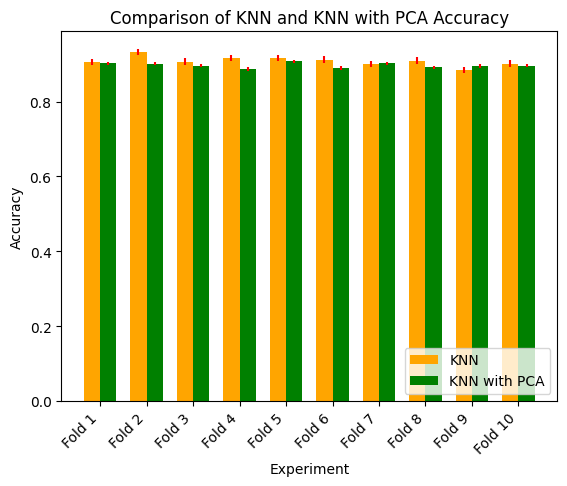

In [161]:
# Plot comparison of KNN with and without PCA
classifier_results_comparison(results_accuracy_knn, results_accuracy_pca, "KNN", "KNN with PCA")

In [160]:
# Answering to the question "Can you increase performance with feature selection?":

# We can see that the accuracy of KNN with Greedy Forward Selection is slightly higher than the accuracy of KNN without feature selection, however, we had to downsample the data to run Greedy Forward Selection (otherwise on our whole dataset it took >12 hours), so we can't say for sure that the accuracy increased because of the feature selection, and not because of downsampling. In any case, when it comes to big amount of data, the Greedy Forward Selection demonstrates very low performance in terms of speed. Moreover, the t-test showed that there is no statistically significant difference between KNN with and without Greedy Selection in terms of accuracy.

# The accuracy of KNN with Fisher's Ratio selected features is lower than the accuracy of KNN without feature selection, so we cannot claim that the performance in terms of accuracy increased. The time spent on Fisher's Ratio feature selection is much lower than the time spent on Greedy Forward Selection, however, training KNN with Fisher's Ratio selected features takes appoximately the same time as training KNN without feature selection.

# PCA demonstrates very good performance in terms of speed. The t-test shows that there is a statistically significant difference between the accuracy of KNN with PCA and the accuracy of KNN without feature selection, however, the difference is relatively slight, also we noticed that it varies per calculation, depending on the results of KNN training. Overall, we can say that at least in our case PCA is a good and relatively fast method to reduce the dimensionality of the data without losing too much of the accuracy of the classifier.